# Evaluate Dynamic Factor Model

This notebook estimates large mixed-frequency (blocked) Dynamic Factor Models following [Bańbura and Modugno, (2014)](https://onlinelibrary.wiley.com/doi/full/10.1002/jae.2306) and [Bok et al. (2018)](https://www.newyorkfed.org/research/staff_reports/sr830), in Python using the `DynamicFactorMQ` class in [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html). GDP in log-differences is the only quarterly variable, taken from the FRED MQ dataset. The other variables are taken from the FRED-MD dataset and transformed using the transformations suggested in the data appendix. The ground truth estimate is GDP from the 2023-02 vintage. 





### Setup

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.api import DynamicFactorMQ
import matplotlib.pyplot as plt
# Some useful functions
def inspect_obj(obj):
    return [x for x in dir(obj) if not x.startswith("_")] 

### Loading Data

In [4]:
data_path = "../../data/FRED/"
# Vintage Data
monthly_vintages = sorted(os.listdir(data_path + "MD"))
quarterly_vintages = sorted(os.listdir(data_path + "QD"))
if monthly_vintages != quarterly_vintages:
    raise Exception("Monthly and quarterly vintage mismatch")

def clean_names(x):
    new_nam = {y: y.replace(" ", "").upper() for y in x.columns}
    return x.rename(columns = new_nam)

# Load Monthly Data
vintage_data = {v[8:15]: dict(
    monthly = clean_names(pd.read_csv(data_path + "MD/" + v, index_col=0, parse_dates=True).to_period(freq="M")), 
    gdp = pd.read_csv(data_path + "QD/" + v, index_col=0, parse_dates=True).to_period(freq="Q")[["GDPC1"]]
) for v in monthly_vintages}

vintage_data.keys()

dict_keys(['2018_05', '2018_06', '2018_07', '2018_08', '2018_09', '2018_10', '2018_11', '2018_12', '2019_01', '2019_02', '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10', '2019_11', '2019_12', '2020_01', '2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07', '2020_08', '2020_09', '2020_10', '2020_11', '2020_12', '2021_01', '2021_02', '2021_03', '2021_04', '2021_05', '2021_06', '2021_07', '2021_08', '2021_09', '2021_10', '2021_11', '2021_12', '2022_01', '2022_02', '2022_03', '2022_04', '2022_05', '2022_06', '2022_07', '2022_08', '2022_09', '2022_10', '2022_11', '2022_12', '2023_01', '2023_02'])

#### Plotting GDP Data

<AxesSubplot: title={'center': 'Real GDP Growth, 2023-02 Vintage'}>

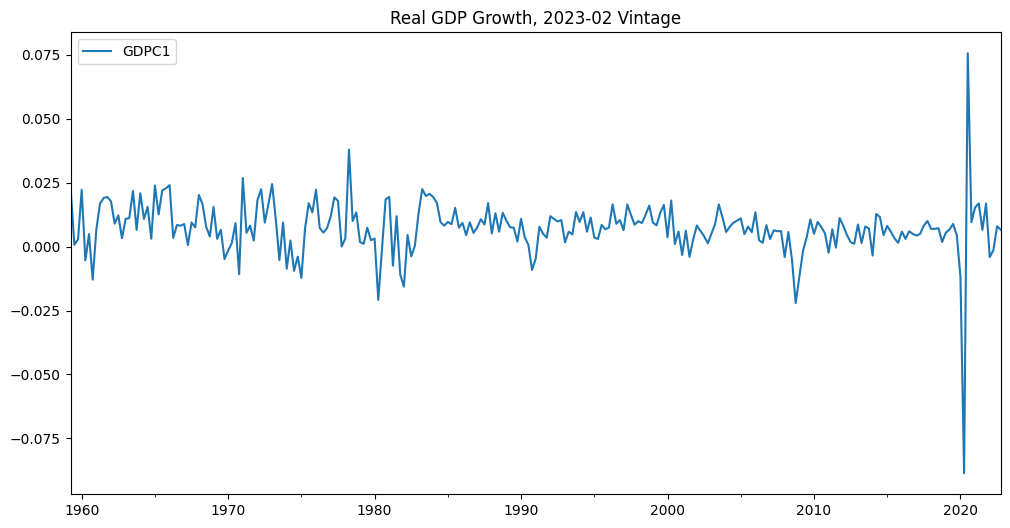

In [5]:
# This plots the ground truth data
vintage_data["2023_02"]["gdp"].plot(title="Real GDP Growth, 2023-02 Vintage", figsize=(12, 6))

In [ ]:
# This gets all the GDP estimates
gdp_all = vintage_data["2018_05"]["gdp"].drop("GDPC1", axis=1)
for k, v in vintage_data.items():
    gdp_all = gdp_all.merge(v["gdp"].rename(columns = {"GDPC1": k}), 
                            how='outer', left_index=True, right_index=True)

gdp_all.head()


In [ ]:
# Plotting all estimates
ax = gdp_all.plot(title="GDP Growth Estimate from All Vintages", figsize=(12, 6), linewidth = 0.2)
ax.legend(ncol=7)
plt.show()

In [ ]:
# ax.get_figure().savefig("figures/GDP_all_vintages.png", dpi = 300, bbox_inches = "tight")
ax.get_figure().savefig("figures/GDP_all_vintages.pdf", format = "pdf", bbox_inches = "tight")

### Labels and Factor Groupings

In [ ]:
# Loading Series Descriptions
series = pd.read_csv(data_path + "FRED-MD Appendix/FRED-MD_updated_appendix.csv", 
                     encoding_errors="ignore")
series.fred = series.fred.transform(lambda y: y.replace(" ", "").upper())
series.groupby("group_name").id.count()

In [ ]:
# Factor Groupings
factors = {l: ['Global', v] for l, v in zip(series.fred, series.group_name)}
factors["GDPC1"] = ['Global', 'Output and Income']

**Factor multiplicities**

The `factor_multiplicities` argument defaults to `1`, but it can be passed a dictionary with keys equal to factor names (from the `factors` argument) and values equal to an integer. Note that the default for each factor is 1, so we only include in this dictionary factors that have multiplicity greater than 1.

In [ ]:
factor_multiplicities = {'Global': 2,
                         'Consumption, Orders, and Inventories': 2,
                         'Money and Credit': 2,
                         'Interest and Exchange Rates': 2}

**Factor orders**

Finally, we need to specify the lag order of the (vector) autoregressions that govern the dynamics of the factors. This is done via the `factor_orders` argument. The `factor_orders` argument also defaults to `1`,

In [ ]:
factor_orders = {'Global': 4, 
                 'Consumption, Orders, and Inventories': 4,  
                 'Housing': 2,
                 'Interest and Exchange Rates': 3, 
                 'Money and Credit': 4,
                 'Output and Income': 2}

In [ ]:
dfm_blocked_2023_02 = DynamicFactorMQ(endog = vintage_data["2023_02"]["monthly"], 
                              endog_quarterly = vintage_data["2023_02"]["gdp"], 
                              factors = factors, 
                              factor_multiplicities = factor_multiplicities, 
                              factor_orders = factor_orders)

In [ ]:
dfm_blocked_2023_02.summary()

In [ ]:
blocked_results_2023_02 = dfm_blocked_2023_02.fit(disp = 10)

In [ ]:
# Another model without separate blocks but 9 global factors
dfm_global_2023_02 = DynamicFactorMQ(endog = vintage_data["2023_02"]["monthly"], 
                                     endog_quarterly = vintage_data["2023_02"]["gdp"], 
                                     factors = 1, 
                                     factor_orders = 3, 
                                     factor_multiplicities = 9) 

In [ ]:
dfm_global_2023_02.summary()

In [ ]:
global_results_2023_02 = dfm_global_2023_02.fit(disp = 10)

### Plotting Factor Estimates

In [ ]:
blocked_results_2023_02.factors.smoothed.plot(title = "Factors from Bocked DFM", figsize = (12, 6))

In [ ]:
global_results_2023_02.factors.smoothed.plot(title = "Factors from Global DFM", figsize = (12, 6))

### Explanatory Power of Factors

In [ ]:
group_counts = series[['fred', 'group_name']].groupby('group_name', sort=False).count()['fred'].cumsum()

def plot_r2_joint(results, group_counts):

    # with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i]
        n = end - start
        text = group_counts.index[i]
        if len(text) > n:
            text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for GDP
    ax.set_xlim(-1.5, results.data.endog.shape[1] + 0.5)
    ax.annotate('GDP', (results.data.endog.shape[1] - 1.1, 1.05), ha='left', rotation=90)

    fig.tight_layout();

In [ ]:
plot_r2_joint(blocked_results_2023_02, group_counts)

In [ ]:
plot_r2_joint(global_results_2023_02, group_counts)

### DFM Predictions

In [ ]:
def plot_prediction(prediction_results, variables, data):

    # The `predicted_mean` attribute gives the same
    # point forecasts that would have been returned from
    # using the `predict` or `forecast` methods.
    point_predictions = prediction_results.predicted_mean[variables]
    start = point_predictions.index[0]
    latest = data.index[-1]

    # We can use the `conf_int` method to get confidence
    # intervals; here, the 95% confidence interval
    ci = prediction_results.conf_int(alpha=0.05)
    lower = ci[[f'lower {name}' for name in variables]]
    upper = ci[[f'upper {name}' for name in variables]]


    # Plot the forecasts and confidence intervals
    # with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot actual data
    data.loc[start:, variables].plot(ax=ax, linestyle='solid',
                                        color=['C0', 'C1', 'C2'])

    # Plot the predictions
    point_predictions.plot(ax=ax, linestyle='dashed',
                            color=['C0', 'C1', 'C2'],
                            legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines(latest, ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', (latest, -1.7))
    ax.set(title='In-sample predictions and out-of-sample forecasts, with 95% confidence intervals', ylim=ylim)
    
    fig.tight_layout()

def monthly_index(x):
    x = x.copy()
    x.index = pd.PeriodIndex(x.index, freq="M")
    return x

In [ ]:
blocked_prediction_2023_02 = blocked_results_2023_02.get_prediction(start='2000', end='2024')
global_prediction_2023_02 = global_results_2023_02.get_prediction(start='2000', end='2024')

In [ ]:
plot_prediction(blocked_prediction_2023_02, ['GDPC1'], monthly_index(vintage_data["2023_02"]["gdp"]))

In [ ]:
plot_prediction(global_prediction_2023_02, ['GDPC1'], monthly_index(vintage_data["2023_02"]["gdp"]))

### Model Evaluation

To Evaluate Model Performance, we pedict GDP using models trained on all vintages for a fixed period from 2000 to 2014, each time saving the date GDP was last available.

In [ ]:
all_predictions = {}

In [ ]:
# Evaluate only on certain vintages, default all 
sel = list(vintage_data.keys())
# sel = sel[54:]
vintage_data_sel = {k:vintage_data[k] for k in sel}

In [ ]:
variables = list(factors.keys())

for k, v in vintage_data_sel.items():
    print(k)
    columns = list(v["monthly"].columns)
    dfm_blocked = DynamicFactorMQ(endog = v["monthly"][[x for x in columns if x in variables]], 
                                  endog_quarterly = v["gdp"], 
                                  factors = {k: factors[k] for k in factors.keys() if k in columns + ["GDPC1"]}, 
                                  factor_multiplicities = factor_multiplicities, 
                                  factor_orders = factor_orders)
    blocked_results = dfm_blocked.fit()
    blocked_prediction = blocked_results.get_prediction(start='2000', end='2024')
    
    print("Global Model")
    dfm_global = DynamicFactorMQ(endog = v["monthly"], 
                                 endog_quarterly = v["gdp"], 
                                 factors = 1, 
                                 factor_orders = 3, 
                                 factor_multiplicities = 9)
    global_results = dfm_global.fit()
    global_prediction = global_results.get_prediction(start='2000', end='2024')

    all_predictions[k] = dict(blocked_dfm = blocked_prediction.summary_frame(endog = -1),
                              global_dfm = global_prediction.summary_frame(endog = -1), 
                              gdp = v["gdp"],
                              gdp_latest = str(v["gdp"].index[-1]))

In [ ]:
blocked_dfm_long = pd.concat({k:v["blocked_dfm"].assign(latest_gdp = v["gdp_latest"]) for k, v in all_predictions.items()}) \
          .reset_index(level=0, names = "vintage")

In [ ]:
global_dfm_long = pd.concat({k:v["global_dfm"].assign(latest_gdp = v["gdp_latest"]) for k, v in all_predictions.items()}) \
          .reset_index(level=0, names = "vintage")

In [ ]:
os.makedirs('results', exist_ok=True)
blocked_dfm_long.to_csv("results/blocked_dfm_long.csv", index_label="year_month")
global_dfm_long.to_csv("results/global_dfm_long.csv", index_label="year_month")

### Now Performance Evaluation

In [6]:
blocked_dfm_long = pd.read_csv("results/blocked_dfm_long.csv", index_col="year_month", 
                               parse_dates=True)
blocked_dfm_long = blocked_dfm_long.loc[blocked_dfm_long.index.month % 3 == 0].to_period(freq="Q")
blocked_dfm_long.latest_gdp = pd.PeriodIndex(blocked_dfm_long.latest_gdp, freq="Q")

global_dfm_long = pd.read_csv("results/global_dfm_long.csv", index_col="year_month", 
                               parse_dates=True)
global_dfm_long = global_dfm_long.loc[global_dfm_long.index.month % 3 == 0].to_period(freq="Q")
global_dfm_long.latest_gdp = pd.PeriodIndex(global_dfm_long.latest_gdp, freq="Q")

In [24]:
res = pd.concat({"blocked" : blocked_dfm_long, "global" : global_dfm_long}) \
        .reset_index(level=0, names = "model") \
        .merge(vintage_data["2023_02"]["gdp"], left_index=True, right_index=True) \
        .reset_index(level=0, names = "year_quarter") 
res["vintage_quarter"] = pd.PeriodIndex(res.vintage.apply(lambda x: x.replace("_", "-")), freq="Q")
res.head()

,year_quarter,model,vintage,mean,mean_se,mean_ci_lower,mean_ci_upper,latest_gdp,GDPC1,vintage_quarter
0,2000Q1,blocked,2018_05,0.009347,0.005276,0.019687,-0.000994,2018Q1,0.003638,2018Q2
1,2000Q1,blocked,2018_06,0.009357,0.005275,0.019696,-0.000982,2018Q1,0.003638,2018Q2
2,2000Q1,blocked,2018_07,0.009461,0.005281,0.019811,-0.000890,2018Q2,0.003638,2018Q3
3,2000Q1,blocked,2018_08,0.009446,0.005283,0.019801,-0.000908,2018Q2,0.003638,2018Q3
4,2000Q1,blocked,2018_09,0.009448,0.005284,0.019804,-0.000907,2018Q2,0.003638,2018Q3


In [25]:
def corr(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_std = np.std(x)
    y_std = np.std(y)
    n = len(x)
    numerator = ((x - x_mean) * (y - y_mean)).sum()
    denominator = n * x_std * y_std
    correlation = numerator / denominator
    return correlation

def metrics(x, y):
    return {"N" : len(y), "r_squared": corr(x, y)**2, "MAE_pgr": np.mean(np.abs(x - y)*100)}

def compute_res(t): # res.latest_gdp
    res_t = res.loc[res.year_quarter == (res.vintage_quarter + t)].groupby("model") \
        .apply(lambda x: metrics(x['mean'], x['GDPC1'])).reset_index()
    return pd.concat([res_t[["model"]], pd.DataFrame(list(res_t.iloc[:, 1]))], axis=1)

In [26]:
results = pd.concat({t : compute_res(t) for t in range(-2, 4)}).reset_index(level=0, names = "trel") \
            .pivot(index = ["trel", "N"], columns="model", values=["r_squared", "MAE_pgr"])

In [27]:
results

r_squared              MAE_pgr          
model     blocked    global    blocked    global
trel N                                          
-2   58  0.919045  0.944215   0.611617  0.497078
-1   58  0.922968  0.937203   0.590755  0.540626
 0   56  0.536954  0.646750   1.078014  0.950775
 1   53  0.133778  0.141975   3.413440  2.239662
 2   50  0.000606  0.000584   8.517923  2.471050
 3   47  0.002658  0.002975  28.596913  2.935459

In [28]:
print(results.to_latex(float_format="%.4f"))

\begin{tabular}{llrrrr}
\toprule
   & {} & \multicolumn{2}{l}{r\_squared} & \multicolumn{2}{l}{MAE\_pgr} \\
   & model &   blocked & global & blocked & global \\
trel & N &           &        &         &        \\
\midrule
-2 & 58 &    0.9190 & 0.9442 &  0.6116 & 0.4971 \\
-1 & 58 &    0.9230 & 0.9372 &  0.5908 & 0.5406 \\
 0 & 56 &    0.5370 & 0.6467 &  1.0780 & 0.9508 \\
 1 & 53 &    0.1338 & 0.1420 &  3.4134 & 2.2397 \\
 2 & 50 &    0.0006 & 0.0006 &  8.5179 & 2.4711 \\
 3 & 47 &    0.0027 & 0.0030 & 28.5969 & 2.9355 \\
\bottomrule
\end{tabular}



/var/folders/zp/cc61fbb560g9pqns4g2wtzz40000gn/T/ipykernel_25310/690236861.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(float_format="%.4f"))
